# 20230224
## 1.增加callback存下best model -->best RECALL (sensitivity)
## 2.下載及修改預存的model
## 3.使用tensorboard..

In [1]:
! pip freeze > requirements.txt

In [27]:
import tensorflow as tf, pandas as pd, faker
import tensorflow_hub as hub, tensorflow_text as text
from sklearn.model_selection import train_test_split
fake=faker.Faker('zh-TW')
list0=[]
list1=[]
list2=[]
for _ in range(300):
    list0.append([0,fake.sentence(20)])
    list1.append([1,fake.sentence(20)])
    list2.append([2,fake.sentence(20)])
df=pd.DataFrame(list0+list1+list2, columns=['Category','Message'])
df['Category'].value_counts()
x_train,x_test,y_train,y_test=train_test_split(df['Message'],df['Category'],stratify=df['Category'],test_size=0.3, random_state=4)

In [14]:
bert_preprocess=hub.KerasLayer('bert_zh_preprocess_3')
bert_encoder=hub.KerasLayer('bert_zh_L-12_H-768_A-12_4')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TEXT (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_3 (KerasLayer)     {'input_mask': (Non  0           ['TEXT[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

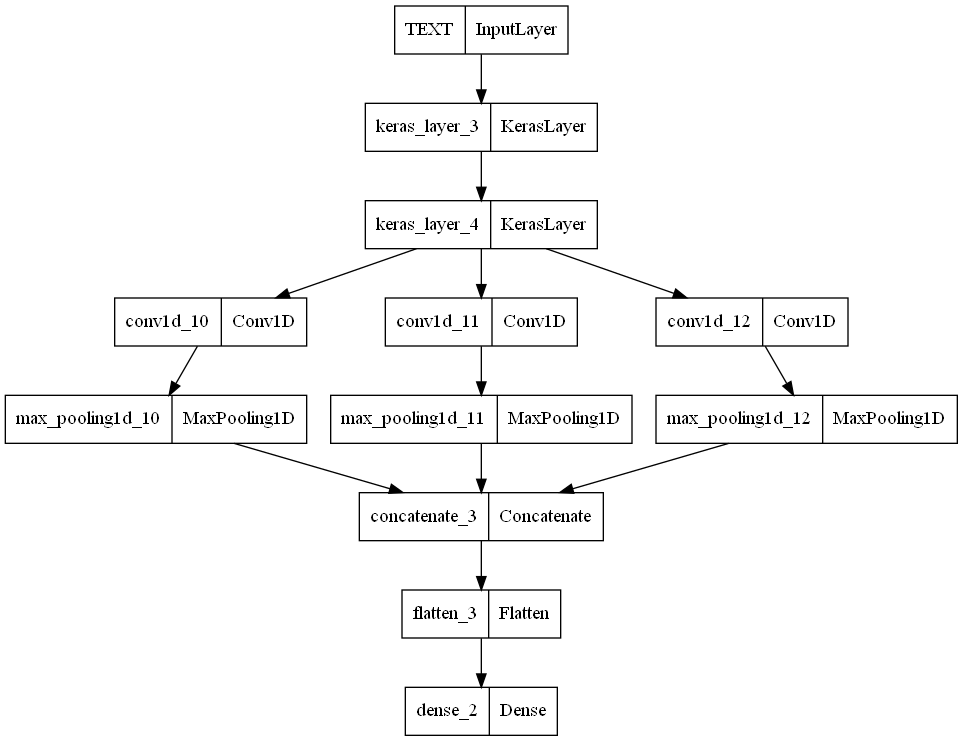

In [28]:
from tensorflow.keras import layers
text_input=layers.Input(shape=(),dtype=tf.string,name='TEXT')
preprocess_text=bert_preprocess(text_input)
encode_text=bert_encoder(preprocess_text)
l=sequence_output=encode_text['sequence_output']
l1=layers.Conv1D(filters=8,kernel_size=2,activation='relu')(l)
l1=layers.MaxPooling1D()(l1)
l2=layers.Conv1D(filters=8,kernel_size=3,activation='relu')(l)
l2=layers.MaxPooling1D()(l2)
l3=layers.Conv1D(filters=8,kernel_size=4,activation='relu')(l)
l3=layers.MaxPooling1D()(l3)
l=layers.Concatenate(axis=1)([l1,l2,l3])
l=layers.Flatten()(l)
outputs=layers.Dense(3,activation='sigmoid')(l)
myModel=tf.keras.Model(inputs=text_input,outputs=outputs)
myModel.summary()
tf.keras.utils.plot_model(myModel)

In [32]:
from tensorflow.keras import metrics
METRICS=[metrics.BinaryAccuracy(name='accuracy'),
         metrics.Precision(name='precision'),
         metrics.Recall(name='recall'),]
myModel.compile(optimizer='Adam',loss='categorical_crossentropy',
                metrics=METRICS)
history=myModel.fit(x=x_train,y=tf.one_hot(y_train,3),validation_split=0.2, epochs=2)

Epoch 1/2
16/16 [==============================] - 104s 6s/step - loss: 1.3152 - accuracy: 0.5086 - precision: 0.3315 - recall: 0.4663 - val_loss: 1.1175 - val_accuracy: 0.5053 - val_precision: 0.3174 - val_recall: 0.4206
Epoch 2/2
16/16 [==============================] - 101s 6s/step - loss: 1.0460 - accuracy: 0.6032 - precision: 0.4316 - recall: 0.6012 - val_loss: 1.1289 - val_accuracy: 0.5026 - val_precision: 0.3155 - val_recall: 0.4206


In [35]:
## Adding callBack...
callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='ckpoint.keras',
                                              save_best_only=True,
                                              moniter='val_recall')]
history=myModel.fit(x_train,tf.one_hot(y_train,3),
                    validation_split=0.3,
                    epochs=10,
                    callbacks=callbacks)

Epoch 1/10
14/14 [==============================] - 111s 8s/step - loss: 0.9720 - accuracy: 0.6425 - precision: 0.4754 - recall: 0.7007 - val_loss: 1.0695 - val_accuracy: 0.5450 - val_precision: 0.3755 - val_recall: 0.5503
Epoch 2/10
14/14 [==============================] - 121s 9s/step - loss: 0.8563 - accuracy: 0.6772 - precision: 0.5098 - recall: 0.8231 - val_loss: 1.1082 - val_accuracy: 0.5503 - val_precision: 0.3942 - val_recall: 0.6508
Epoch 3/10
14/14 [==============================] - 112s 8s/step - loss: 0.6922 - accuracy: 0.7105 - precision: 0.5403 - recall: 0.8821 - val_loss: 1.1128 - val_accuracy: 0.5714 - val_precision: 0.3953 - val_recall: 0.5397
Epoch 4/10
14/14 [==============================] - 139s 10s/step - loss: 0.5217 - accuracy: 0.7906 - precision: 0.6213 - recall: 0.9524 - val_loss: 1.2493 - val_accuracy: 0.4815 - val_precision: 0.3220 - val_recall: 0.5026
Epoch 5/10
14/14 [==============================] - 115s 8s/step - loss: 0.3717 - accuracy: 0.8587 - precis

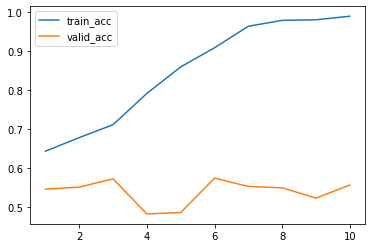

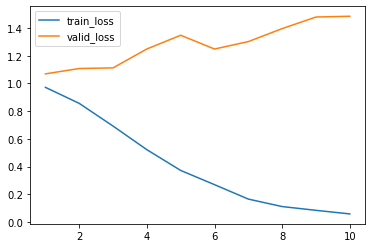

In [38]:
from matplotlib import pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='train_acc')
plt.plot(epochs,val_acc,label='valid_acc')
plt.legend()
plt.show()
plt.plot(epochs,loss,label='train_loss')
plt.plot(epochs,val_loss,label='valid_loss')
plt.legend()
plt.show()

In [47]:
test_model=tf.keras.models.load_model('ckpoint.keras',custom_objects={'KerasLayer': hub.KerasLayer})
results=test_model.evaluate(x=x_test,y=tf.one_hot(y_test,3))
##print(f'Test accuracy:{test_acc:.3f}, Test loss:{test_loss:.3f}')

9/9 [==============================] - 44s 5s/step - loss: 1.1124 - accuracy: 0.4914 - precision: 0.3415 - recall: 0.5667


In [48]:
results

[1.112420678138733,
 0.49135804176330566,
 0.3415178656578064,
 0.5666666626930237]

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TEXT (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_3 (KerasLayer)     {'input_mask': (Non  0           ['TEXT[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

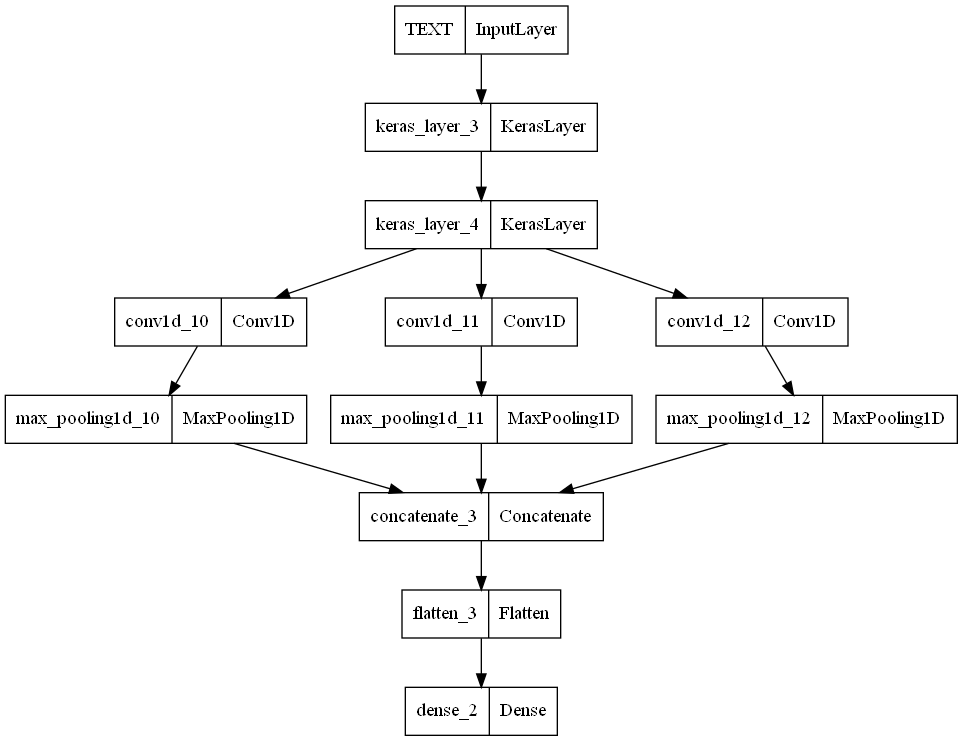

In [44]:
test_model.summary()
tf.keras.utils.plot_model(test_model)

In [45]:
test_model.trainable=True
for layer in test_model.layers[:-2]:
    layer.trainable=False

In [46]:
test_model.fit(x_train,tf.one_hot(y_train,3),epochs=2)

Epoch 1/2
20/20 [==============================] - 109s 5s/step - loss: 0.9147 - accuracy: 0.6302 - precision: 0.4669 - recall: 0.7714
Epoch 2/2
20/20 [==============================] - 109s 5s/step - loss: 0.7445 - accuracy: 0.6656 - precision: 0.4991 - recall: 0.8825


In [51]:
mySentence=fake.sentence(20)
predict=myModel.predict([mySentence])
predict

array([[0.19515216, 0.02073911, 0.72236085]], dtype=float32)